In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
#np.random.seed(1)

In [2]:
train_dataset = h5py.File('datasets/train_signs.h5', 'r')
train_set_x_orig = np.array(train_dataset['train_set_x'][:])
train_set_y_orig = np.array(train_dataset['train_set_y'][:])
train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))

test_dataset = h5py.File('datasets/test_signs.h5', 'r')
test_set_x_orig = np.array(test_dataset['test_set_x'][:])
test_set_y_orig = np.array(test_dataset['test_set_y'][:])
test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

y = 2


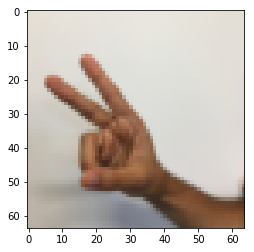

In [3]:
index = 6
plt.imshow(train_set_x_orig[index])
print ("y = " + str(np.squeeze(train_set_y_orig[:, index])))

In [4]:
def convert_to_one_hot(Y, C):
    return np.eye(C)[Y.reshape(-1)].T

In [5]:
X_train = train_set_x_orig/255.
X_test = test_set_x_orig/255.
Y_train = convert_to_one_hot(train_set_y_orig, 6).T
Y_test = convert_to_one_hot(test_set_y_orig, 6).T

In [6]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """
    
    X = tf.placeholder(tf.float32, shape = (None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32, shape = (None, n_y))
    
    return X, Y

In [7]:
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


In [8]:
def initialize_parameters():
    #tf.set_random_seed(1)                              
    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer())

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [9]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

W1 = [-0.12967333  0.14239003  0.14689215 -0.1808487  -0.03871793 -0.17310303
  0.0880519   0.00813855]
W2 = [-0.10169637 -0.23175627 -0.12729156  0.12966704  0.21240824 -0.2225318
  0.00324082  0.16975367 -0.02580321  0.21291089 -0.08873034 -0.14210206
  0.21706182  0.13382077  0.03866053  0.14766741]


In [10]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides = [1, 1, 1, 1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1, 8, 8, 1], strides = [1, 8, 8, 1], padding = 'SAME')
    
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides = [1, 1, 1, 1], padding = 'SAME')
    
    #RELU
    A2 = tf.nn.relu(Z2)
    
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding = 'SAME')
    
    #FLATTEN
    P3 = tf.contrib.layers.flatten(P2)
    
    # FULLY-CONNECTED without non-linear activation function (not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None"
    Z3 = tf.contrib.layers.fully_connected(P3, 6, activation_fn = None)
    
    return Z3

In [18]:
tf.reset_default_graph()

with tf.Session() as sess:
    #np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = " + str(a))

Z3 = [[ 4.88261795  0.26886594 -1.81342149  3.10876226 -3.82742858 -5.86125851]
 [ 4.54017639  0.06065091 -1.5686146   3.24866438 -3.51856279 -5.79547024]]


In [12]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    return cost

In [13]:
tf.reset_default_graph()

with tf.Session() as sess:
    #np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))

cost = 6.11657


In [14]:
def random_mini_batches(X, Y, mini_batch_size = 64):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    m = X.shape[0]
    mini_batches = []
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation, :]
    
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    # number of mini batches of size mini_batch_size in your partitionning
    num_complete_minibatches = math.floor(m/mini_batch_size)
    
    for k in range(num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : (k + 1) * mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : (k + 1) * mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [15]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009, num_epochs = 100, minibatch_size = 64, 
         print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    ops.reset_default_graph()                   # to be able to rerun the model without overwriting tf variables
    #tf.set_random_seed(1)                       # to keep results consistent (tensorflow seed)
    #seed = 3                                    # to keep results consistent (numpy seed)
    
    (m, n_H0, n_W0, n_c0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(64, 64, 3, 6)
    
    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
    
    # Start the session to computer the tensorflow graph
    with tf.Session() as sess:
        # Run the initialization
        sess.run(init)
        
        #Do the training loop
        for epoch in range(num_epochs):
            minibatch_cost = 0
            # number of minibatches of size minibatch_size in the train set
            num_minibatch = int(m / minibatch_size) 
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)
            
            for minibatch in minibatches:
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost,
                # the feedict should contain a minibatch for (X,Y).
                _, temp_cost = sess.run([optimizer, cost], feed_dict = {X : minibatch_X, Y : minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatch
                
            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print('Cost after each epoch', str(epoch), ':', str(minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iteration (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

        # Calculate the accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

        train_accuracy = accuracy.eval({X: X_train, Y:Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y:Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
    return train_accuracy, test_accuracy, parameters

Cost after each epoch 0 : 1.92361839861
Cost after each epoch 5 : 1.57915534079
Cost after each epoch 10 : 1.31190671772
Cost after each epoch 15 : 1.03600694239
Cost after each epoch 20 : 0.919033247977
Cost after each epoch 25 : 0.810891974717
Cost after each epoch 30 : 0.710741907358
Cost after each epoch 35 : 0.659222166985
Cost after each epoch 40 : 0.594838175923
Cost after each epoch 45 : 0.569228963926
Cost after each epoch 50 : 0.582018621266
Cost after each epoch 55 : 0.511359505355
Cost after each epoch 60 : 0.455995006487
Cost after each epoch 65 : 0.42133858148
Cost after each epoch 70 : 0.446965774521
Cost after each epoch 75 : 0.412174394354
Cost after each epoch 80 : 0.389782642946
Cost after each epoch 85 : 0.366026289761
Cost after each epoch 90 : 0.321899315342
Cost after each epoch 95 : 0.320527302101


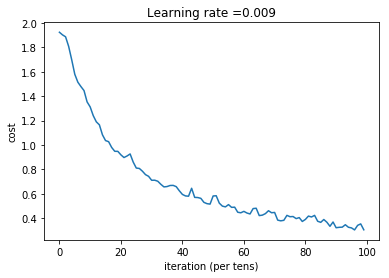

Train Accuracy: 0.906482
Test Accuracy: 0.85


In [16]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)